# Train and Predict
In this notebook i train the model using LSTM neural network and Word2Vector word embedding on the given data.

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [223]:
df = pd.read_csv("stanford-sentiment-treebank.train.csv")             #data on which the model will trained

In [224]:
df.head()

,id,phrase,sentiment,fine,coarse
0,22935,! ',0.52778,neutral,neutral
1,18235,! '',0.50000,neutral,neutral
2,179257,! Alas,0.44444,neutral,neutral
3,22936,! Brilliant,0.86111,very positive,positive
4,40532,! Brilliant !,0.93056,very positive,positive


In [225]:
new_df=df.rename(columns={'coarse':'sentiments'})[['phrase','sentiments']]         #create new dataframe taking only text and their respective sentiments

In [226]:
new_df.head()

,phrase,sentiments
0,! ',neutral
1,! '',neutral
2,! Alas,neutral
3,! Brilliant,positive
4,! Brilliant !,positive


In [227]:
#new_df = new_df[new_df.sentiments != "neutral"].reset_index(drop=True)   # if not want to include neutral sentiment

In [228]:
new_df = new_df[:80000]  #large dataset take large time to train so taken a sufficient data. More data will help to improve the accuracy

In [229]:
new_df['phrase'][50]

"' is the kind of engaging historical drama that Hollywood appears to have given up on in favor of sentimental war movies in the vein of ` We Were Soldiers . '"

## **Data preprocessing**

The first step when building a neural network model is getting your data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer. We'll also want to clean it up a bit.

You can see an example of the reviews data above. We'll want to get rid of all unnecessary words and special characters which have not so much importance as for training purpose. Let's remove all punctuation,special characters and convert to lower case.

In [ ]:
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
stop_words.remove('not')

In [231]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
corpus=[]
for i in range(0,len(new_df)):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',new_df['phrase'][i])
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    review=[stemmer.stem(word) for word in review]
    review=' '.join(review)
    corpus.append(review)

In [232]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(new_df,test_size=0.20,random_state=123)         #split the data to train and test

In [233]:
documents = [text.split() for text in train_df.phrase]

In [234]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300,                       
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [235]:
w2v_model.build_vocab(documents)      #Create a word2vector from the given data set

In [236]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 6665


In [237]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)            #Training Word2Vector model

(13197456, 19743000)

In [239]:
w2v_model.wv.most_similar("beautiful")                      #showing closest word

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('mad', 0.3633460998535156),
 ('contemplative', 0.33745622634887695),
 ('self-satisfied', 0.33588823676109314),
 ('sexually', 0.3321208655834198),
 ('unpleasant', 0.3214070796966553),
 ('thought-provoking', 0.3183754086494446),
 ('observant', 0.3173168897628784),
 ('chilling', 0.3171353340148926),
 ('sexuality', 0.3055786192417145),
 ('vivid', 0.30030956864356995)]

In [240]:
w2v_model.wv.most_similar("movie")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('film', 0.4467891752719879),
 ('picture', 0.3497546315193176),
 ('thing', 0.34596139192581177),
 ('flick', 0.30763041973114014),
 ('documentary', 0.30453354120254517),
 ('cartoon', 0.2991136908531189),
 ('sequel', 0.29513829946517944),
 ('Spy', 0.2857236862182617),
 ('project', 0.2849161922931671),
 ('thriller', 0.2817550301551819)]

In [241]:
w2v_model.wv.most_similar("amazing")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('institution', 0.5018695592880249),
 ('Hardly', 0.49068161845207214),
 ('irresistible', 0.4683215916156769),
 ('astounding', 0.45489925146102905),
 ('amusement', 0.4511985182762146),
 ('astonishingly', 0.4453026354312897),
 ('layered', 0.4427262842655182),
 ('Buy', 0.4301478862762451),
 ('exquisite', 0.4219828248023987),
 ('ungainly', 0.4201950430870056)]

In [242]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.phrase)               #Use Tokenizer to get the numerical data

In [243]:
tokenizer.word_index                        #map each word with an unique integer based on their frequency of occurence.

{'the': 1,
 'a': 2,
 'and': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'in': 7,
 'that': 8,
 'it': 9,
 'as': 10,
 'an': 11,
 'for': 12,
 'with': 13,
 'its': 14,
 'movie': 15,
 'film': 16,
 'but': 17,
 'this': 18,
 'be': 19,
 'by': 20,
 "it's": 21,
 'on': 22,
 'more': 23,
 'you': 24,
 'not': 25,
 "''": 26,
 'has': 27,
 'like': 28,
 'at': 29,
 'one': 30,
 'his': 31,
 'are': 32,
 'from': 33,
 'than': 34,
 'about': 35,
 'all': 36,
 'have': 37,
 "'s": 38,
 'or': 39,
 'good': 40,
 'so': 41,
 "'": 42,
 'story': 43,
 'just': 44,
 'out': 45,
 'too': 46,
 'if': 47,
 'into': 48,
 'up': 49,
 'i': 50,
 'who': 51,
 'most': 52,
 'funny': 53,
 'even': 54,
 'time': 55,
 'can': 56,
 'comedy': 57,
 'no': 58,
 'characters': 59,
 'much': 60,
 'well': 61,
 'bad': 62,
 'little': 63,
 'some': 64,
 'what': 65,
 'make': 66,
 'very': 67,
 'been': 68,
 'way': 69,
 'enough': 70,
 'their': 71,
 'your': 72,
 'makes': 73,
 'best': 74,
 'life': 75,
 'any': 76,
 'will': 77,
 'work': 78,
 'us': 79,
 'great': 80,
 'made': 81,
 'l

In [244]:
vocab_size=len(tokenizer.word_index)+1
vocab_size                                                        #size of vocubalary created 

17931

In [245]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.phrase), maxlen=300)       #apply padding to get the same length
X_train/17931                                                                            #Normalize the data 

array([[0.        , 0.        , 0.        , ..., 0.        , 0.00178462,
        0.06971167],
       [0.        , 0.        , 0.        , ..., 0.00066923, 0.0034577 ,
        0.04851932],
       [0.        , 0.        , 0.        , ..., 0.00066923, 0.00100385,
        0.01812503],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00117116, 0.01751157,
        0.22307735],
       [0.        , 0.        , 0.        , ..., 0.00039039, 0.00936925,
        0.11811946],
       [0.        , 0.        , 0.        , ..., 0.08727901, 0.10155596,
        0.00317885]])

In [246]:
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.phrase), maxlen=300)
X_test/17931

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.67308014e-04, 1.03284814e-01, 1.43884892e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.67692822e-03, 5.57693380e-05, 7.93597680e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.03463276e-03, 1.61731080e-03, 4.19943115e-02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.38798728e-01, 1.67308014e-04, 7.30578328e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.50577213e-03, 9.31347945e-03, 4.51731638e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.17673303e-02, 2.22073504e-01, 2.28654286e-02]])

In [247]:
y_train=train_df.sentiments
y_train.head()

41251    positive
31074    negative
33410    positive
74109    positive
25690    positive
Name: sentiments, dtype: object

In [248]:
y_test=test_df.sentiments
y_test.head()

23438    positive
78749    negative
43994    negative
25959    positive
20526    positive
Name: sentiments, dtype: object

In [249]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test=labelencoder.fit_transform(y_test)                   #LabelEncoder is used to convert the sentiments into numerical data

In [250]:
y_train.shape

(64000,)

In [251]:
y_test.shape

(16000,)

# Embedding Matrix

In [252]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)                               #created an embedding Matrix from word2vector for embedding layer

(17931, 300)


In [253]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

# LSTM

In [254]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,activation="sigmoid"))       #use lstm for better result
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 300)          5379300   
_________________________________________________________________
dropout_5 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 5,539,801
Trainable params: 160,501
Non-trainable params: 5,379,300
_________________________________________________________________


In [255]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [256]:
model_history=model.fit(X_train, y_train,batch_size=1024,epochs=10,validation_split=0.1,verbose=1)

Epoch 1/10
57/57 [==============================] - 713s 13s/step - loss: 0.6281 - accuracy: 0.6388 - val_loss: 0.5634 - val_accuracy: 0.7077
Epoch 2/10
57/57 [==============================] - 712s 12s/step - loss: 0.5689 - accuracy: 0.6990 - val_loss: 0.5239 - val_accuracy: 0.7369
Epoch 3/10
57/57 [==============================] - 715s 13s/step - loss: 0.5497 - accuracy: 0.7165 - val_loss: 0.5207 - val_accuracy: 0.7298
Epoch 4/10
57/57 [==============================] - 717s 13s/step - loss: 0.5379 - accuracy: 0.7247 - val_loss: 0.5049 - val_accuracy: 0.7517
Epoch 5/10
57/57 [==============================] - 714s 13s/step - loss: 0.5297 - accuracy: 0.7294 - val_loss: 0.5223 - val_accuracy: 0.7283
Epoch 6/10
57/57 [==============================] - 717s 13s/step - loss: 0.5270 - accuracy: 0.7319 - val_loss: 0.4910 - val_accuracy: 0.7553
Epoch 7/10
57/57 [==============================] - 710s 12s/step - loss: 0.5193 - accuracy: 0.7375 - val_loss: 0.4881 - val_accuracy: 0.7639
Epoch 

Train the models for 10 epochs, we can increase the accuracy by increasing the number of epochs.

In [257]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

# Data Visualization for the result

Text(0.5, 1.0, 'Training and Validation Accuracy')

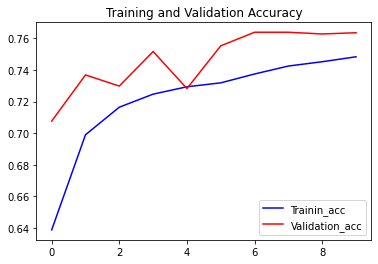

In [258]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

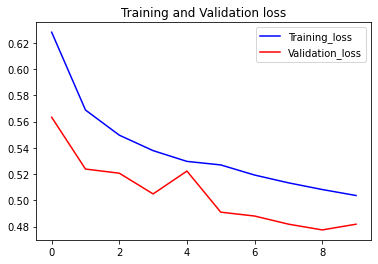

In [259]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

losses will not converged yet ,so we can increase the no of epoch to get better result

In [348]:
model.evaluate(X_test, y_test)           #testing the model on test data

500/500 [==============================] - 64s 127ms/step - loss: 0.4803 - accuracy: 0.7707


[0.48028406500816345, 0.7707499861717224]

# For User Input Data

All the preprocessing as done earlier

In [307]:
def preprocess(text):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',text)
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    review=[stemmer.stem(word) for word in review]
    print(review)
    review=pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=300)      
    return review

### prediction

In [308]:
def prediction(review):
    review=preprocess(review)
    score=model.predict(review)
    score=score[0]
    if score<=0.5:
        print("Negative")
    else:
        print("Positive")
    print(score)

In [313]:
prediction("food is good")

['food', 'good']
Positive
[0.868377]


In [314]:
prediction("cheapest product")

['cheapest', 'product']
Negative
[0.27350035]


In [315]:
prediction("worst movie")

['worst', 'movi']
Negative
[0.2505594]


In [339]:
def prediction1(review):
    review=preprocess(review)
    score=model.predict(review)
    score=score[0]
    if score<=0.2:
        return "Very Negative"
    elif score>0.2 and score<=0.4:
        return "Negative"
    elif score>0.4 and score<=0.6:
        return "Neutral"
    elif score>0.6 and score<=0.8:
        return "Positive"
    else:
        return "Positive"

## Taking Amazon reviews for prediction

In [340]:
Amazon_reviews = pd.read_csv("reviews.csv")

In [341]:
Amazon_reviews.head()

,Unnamed: 0,Cust_name,Mob_name,reviews
0,0,Akash peelwa,Redmi Note 9 Pro,PLZZ read this complete information before buy...
1,1,manish,Redmi Note 9 Pro,good batter backupgood cameragood mob designno...
2,2,Sayantan Dey,Redmi Note 9 Pro,Nice product in this price... Good quality and...
3,3,Janvhi J.,Redmi Note 9 Pro,"Hi all,As I have bought redmi note 9 pro on fi..."
4,4,VINOD SOMVANSHI,Redmi Note 9 Pro,Don't go for this mobile as I face issue with ...


In [342]:
sent = []
for i in range(len(Amazon_reviews)):
  sent.append(prediction1(Amazon_reviews["reviews"][i]))    #predictions on reviews added to the sent list

['plzz', 'read', 'complet', 'inform', 'buy', 'amazonthey', 'not', 'refund', 'product', 'got', 'defect', 'amazon', 'worst', 'provid', 'servic', 'option', 'buy', 'flipkart', 'go', 'wast', 'time', 'amazonregard', 'mobileworst', 'mobil', 'ever', 'seenbatteri', 'charg', 'time', 'expect', 'batteri', 'draina', 'problem', 'therecamera', 'stuck', 'click', 'pictur', 'poor', 'camera', 'qualiti', 'said', '48', 'mp', 'like', '12mp', 'game', 'lover', 'plzz', 'tri', 'anoth', 'mobil', 'perform', 'low', 'told', 'amazon', 'custom', 'care', 'take', 'product', 'back', 'not', 'help', 'instead', 'want', 'go', 'servic', 'center', 'covid19', 'situat', 'red', 'zone', 'provid', 'home', 'visit', 'technician', 'life', 'import', 'custom', 'custom', 'get', 'infect', 'ok', 'thank', 'amazon', 'servic', 'hate', 'amazon', 'tiktok', 'unistal', 'app', 'right', 'also', 'recommend', 'friend', 'relat', 'not', 'buy', 'anyth', 'amazon', 'worst']
['good', 'batter', 'backupgood', 'cameragood', 'mob', 'designno', 'issu']
['nice'

In [343]:
Amazon_reviews["Sentiments"] =sent                     #Map all the sentiments to respective reviews in dataframe

In [344]:
Amazon_reviews.drop(columns=["Unnamed: 0"],inplace=True)

# Result

In [345]:
Amazon_reviews.head(40)                                 #Final dataframe we get 

,Cust_name,Mob_name,reviews,Sentiments
0,Akash peelwa,Redmi Note 9 Pro,PLZZ read this complete information before buy...,Very Negative
1,manish,Redmi Note 9 Pro,good batter backupgood cameragood mob designno...,Positive
2,Sayantan Dey,Redmi Note 9 Pro,Nice product in this price... Good quality and...,Positive
3,Janvhi J.,Redmi Note 9 Pro,"Hi all,As I have bought redmi note 9 pro on fi...",Positive
4,VINOD SOMVANSHI,Redmi Note 9 Pro,Don't go for this mobile as I face issue with ...,Positive
5,jaspreet,Redmi Note 9 Pro,Beauty and the beast combination with snapdrag...,Neutral
6,nouman ahmed,Redmi Note 9 Pro,Poor camera quality. Breadth too wide to grip ...,Positive
7,riaz Khan,Redmi Note 9 Pro,The phone looks very good and premium but I no...,Positive
8,Arun kumar,Redmi Note 9 Pro,"Super camera, battery, sound amazing very much",Neutral
9,Rajesh S,Redmi Note 9 Pro,Camera Protrait mode Not good but 48 MP cam Go...,Very Negative


In [347]:
Amazon_reviews.to_csv("Amazon_reviews_sentiments.csv",index=True)  #Save result in csv file

## please ask free if there is any confusion